In [167]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA, FactorAnalysis
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cosine

from sklearn import set_config
from sklearn.base import clone, BaseEstimator, TransformerMixin

set_config(transform_output='pandas')

# Load data

In [2]:
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets

| Variable          | Type        | Description                                       |
|-------------------|-------------|---------------------------------------------------|
| Age               | Continuous  | Age                                               |
| Height            | Continuous  | Height                                            |
| Weight            | Continuous  | Weight                                            |
| family_Overweigth | Binary      | Has   or had a family member with overweight?     |
| FAVC              | Binary      | Do   you eat high caloric food frequently?        |
| FCVC              | Integer     | Do   you usually eat vegetables in your meals?    |
| NCP               | Continuous  | How   many main meals do you have daily?          |
| CAEC              | Categorical | Do   you eat any food between meals?              |
| SMOKE             | Binary      | Do   you smoke?                                   |
| CH2O              | Continuous  | How   much water do you drink daily?              |
| SCC               | Binary      | Do   you monitor the calories you eat daily?      |
| FAF               | Continuous  | How   often do you have physical activity?        |
| TUE               | Integer     | How   much time do you use technological devices. |
| CALC              | Categorical | How   often do you drink alcohol?                 |
| MTRANS            | Categorical | Which   transportation do you usually use?        |
| NObeyesdad [Target]        | Categorical | Obesity   level                                   |

In [3]:
df_obesity = pd.concat([X, y], axis=1)
df_obesity.head(2)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight


# Preprocessing

In [4]:
df_obesity['IMC'] = df_obesity['Weight'] / (df_obesity['Height'] ** 2)
df_obesity.head(2)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,IMC
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.386526
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,24.238227


In [164]:
cat_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
full_minmax_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'IMC']
minmax_features = ['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'),
)
minmax_pipe = make_pipeline(
    MinMaxScaler((0, 1)),
)

full_preprocessor = make_column_transformer(
    (cat_pipe, cat_features),
    (minmax_pipe, full_minmax_features),
    verbose_feature_names_out=False
)

preprocessor = make_column_transformer(
    (cat_pipe, cat_features),
    (minmax_pipe, minmax_features),
    verbose_feature_names_out=False
)

In [154]:
X = full_preprocessor.fit_transform(df_obesity.drop(columns=['NObeyesdad']))
X_base = X.drop(columns=['IMC', 'Height', 'Weight'])

In [7]:
X_base.shape

(2111, 24)

In [8]:
X_base.head(2)

,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Always,...,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,Age,FCVC,NCP,CH2O,FAF,TUE
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.148936,0.5,0.666667,0.5,0.0,0.5
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.148936,1.0,0.666667,1.0,1.0,0.0


# Components analysis

In [9]:
pca = PCA(n_components=10, random_state=2024)
X_pca = pca.fit_transform(X_base)
X_pca.head(2)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9
0,-0.744159,0.724108,0.118504,-0.556887,-0.200867,0.307081,-0.175168,-0.630771,-0.443234,0.373062
1,0.531360,0.308134,-0.183417,-0.189568,-0.050041,1.388366,-0.249121,-0.327481,0.065363,-0.130017


In [10]:
pca.explained_variance_ratio_.cumsum()

array([0.20650515, 0.38394713, 0.5072174 , 0.61536888, 0.67221496,
       0.72403881, 0.76814097, 0.80743406, 0.84181933, 0.86926353])

In [11]:
X_pca.shape

(2111, 10)

In [12]:
X_corr = X_pca.copy()
X_corr['IMC'] = X['IMC']

In [13]:
X_corr.head(2)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,IMC
0,-0.744159,0.724108,0.118504,-0.556887,-0.200867,0.307081,-0.175168,-0.630771,-0.443234,0.373062,0.301162
1,0.531360,0.308134,-0.183417,-0.189568,-0.050041,1.388366,-0.249121,-0.327481,0.065363,-0.130017,0.297240


In [14]:
X_corr.corr()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,IMC
pca0,1.000000e+00,-1.270541e-15,9.239828e-16,8.562782e-16,3.986003e-15,4.576008e-15,5.261571e-15,-3.533847e-15,1.353631e-14,1.993313e-14,0.277510
pca1,-1.270541e-15,1.000000e+00,-1.056792e-15,4.229307e-16,-5.916648e-15,-6.706824e-15,-7.088522e-15,6.260838e-15,-2.266412e-14,-2.473257e-14,-0.198547
pca2,9.239828e-16,-1.056792e-15,1.000000e+00,9.810270e-16,7.412112e-15,1.059521e-14,7.870991e-15,-8.577995e-15,3.055607e-14,3.411335e-14,0.301781
pca3,8.562782e-16,4.229307e-16,9.810270e-16,1.000000e+00,-4.730850e-15,-1.070855e-14,-8.473420e-15,1.090846e-14,-2.796692e-14,-4.256435e-14,-0.401555
pca4,3.986003e-15,-5.916648e-15,7.412112e-15,-4.730850e-15,1.000000e+00,5.443579e-15,1.042949e-14,-6.211283e-15,3.351629e-14,3.473742e-14,0.210621
pca5,4.576008e-15,-6.706824e-15,1.059521e-14,-1.070855e-14,5.443579e-15,1.000000e+00,-4.719822e-15,9.608426e-15,-1.491027e-14,-3.110027e-14,0.038603
pca6,5.261571e-15,-7.088522e-15,7.870991e-15,-8.473420e-15,1.042949e-14,-4.719822e-15,1.000000e+00,-5.905478e-16,1.058040e-14,7.374696e-15,-0.156120
pca7,-3.533847e-15,6.260838e-15,-8.577995e-15,1.090846e-14,-6.211283e-15,9.608426e-15,-5.905478e-16,1.000000e+00,3.121123e-15,1.388918e-14,0.026388
pca8,1.353631e-14,-2.266412e-14,3.055607e-14,-2.796692e-14,3.351629e-14,-1.491027e-14,1.058040e-14,3.121123e-15,1.000000e+00,2.002556e-14,0.039529
pca9,1.993313e-14,-2.473257e-14,3.411335e-14,-4.256435e-14,3.473742e-14,-3.110027e-14,7.374696e-15,1.388918e-14,2.002556e-14,1.000000e+00,-0.082817


In [15]:
pd.DataFrame(pca.components_, columns=X_base.columns)

,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Always,...,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,Age,FCVC,NCP,CH2O,FAF,TUE
0,-0.131615,-0.022224,0.077893,-0.013085,-0.065073,0.065783,0.012375,0.002591,-0.008918,-0.000671,...,-0.002977,-0.004790,0.249018,-0.024058,-0.033631,0.055999,0.027362,0.040555,-0.076019,-0.022492
1,-0.369141,-0.190582,-0.104041,0.012124,0.215877,-0.247463,0.019462,-0.005891,0.051161,0.000015,...,-0.003715,-0.001983,0.551180,-0.010534,-0.120502,0.051163,-0.048489,-0.042000,-0.006601,0.084721
2,0.511874,0.343902,0.159095,-0.038576,-0.322194,0.386457,-0.025687,-0.007415,-0.081124,-0.000662,...,0.000398,-0.009062,0.374750,-0.033349,-0.062068,-0.086831,0.003064,0.136304,0.059302,0.140087
3,0.708479,-0.322246,-0.120584,0.054547,0.300968,-0.439435,0.083920,0.021260,0.037422,0.001906,...,0.006613,0.013033,0.027236,0.037350,-0.052585,-0.144724,0.045154,0.033479,0.154614,0.002717
4,-0.032195,0.730883,0.226389,0.034049,0.386403,-0.405951,-0.014501,0.018944,-0.067085,0.002644,...,-0.007022,0.000723,0.012892,-0.031608,0.037184,0.132548,0.143998,0.220534,-0.022862,-0.003320
5,-0.086691,0.037154,-0.527398,0.013810,-0.119961,0.076233,0.029917,0.005376,0.133587,-0.001391,...,0.015259,0.001706,-0.061525,0.092760,-0.029204,0.252992,0.159353,0.599828,0.442029,-0.099915
6,-0.134344,-0.144717,0.254338,0.025492,0.024266,0.003556,-0.053315,0.000505,0.012581,0.003032,...,-0.002527,-0.013424,-0.117265,0.061702,-0.097037,-0.087610,0.192727,0.125259,0.255015,0.849911
7,-0.051394,-0.327256,0.642587,0.018008,-0.098930,-0.088187,0.169109,-0.049812,-0.020798,-0.001272,...,-0.008629,0.000294,0.041251,-0.098217,0.015402,0.066759,-0.213849,0.523468,0.072464,-0.272273
8,0.034106,-0.103736,0.287532,-0.065304,0.093379,0.120202,-0.148277,-0.013189,-0.025577,-0.004059,...,-0.000456,-0.000971,0.052159,-0.040011,-0.025439,0.379821,0.503862,-0.379433,0.476143,-0.243759
9,-0.137625,-0.060248,-0.024798,0.000505,-0.028614,0.002976,0.025134,-0.052865,-0.099448,-0.005200,...,0.003828,0.000485,0.056919,-0.090346,-0.012739,-0.641491,0.646871,0.195821,-0.155336,-0.185808


## Analisis
- Reduccion del IMC:
    - La reduccion del IMC esta mayormente explicado por el componente pca3, al romper este componente en los diferentes features que lo integran, vemos que Gender_Male, tiene gran peso sobre este componente, es decir ser hombre tiende a aportar a la reduccion del IMC.
    - En el mismo componente pca3, encontramos una segunda variable con un peso alto, CAEC_Sometimes, lo cual implica que comer muy poco entre comidas aporta de forma significativa a la reduccion del IMC.
- Incremento del IMC:
    - Encontramos 3 componentes que realizan los mayores aportes al incremento del IMC, pca0, pca2, pca4. En pca4 encontramos un punto curioso en el cual CAEC_Sometimes, se contradice con los aportes negativos de pca3. Esto se explica debido a que NCP (Comidas principales al dia) y FAF (Actividad fisica)

# Clustering

In [16]:
k_values = range(2, 11)
eps_range = [i/10 for i in range(1, 41)]

In [113]:
def calculate_cluster_silhouette_scores_n_cluster(X, cluster, k_values) -> tuple[list, list, list]:
    silhouette_scores_euclidean = []
    silhouette_scores_manhattan = []
    silhouette_scores_cosine = []
    for k in k_values:
        try:
            cluster.set_params(n_clusters=k)
        except:
            print("No n_clusters parameter")
            continue
        e_labels = cluster.fit_predict(X)
        m_labels = cluster.fit_predict(X)
        c_labels = cluster.fit_predict(X)

        silhouette_scores_euclidean.append(silhouette_score(X, e_labels, metric='euclidean'))
        silhouette_scores_manhattan.append(silhouette_score(X, m_labels, metric='manhattan'))
        silhouette_scores_cosine.append(silhouette_score(X, c_labels, metric='cosine'))
    return silhouette_scores_euclidean, silhouette_scores_manhattan, silhouette_scores_cosine

def calculate_cluster_silhouette_scores_eps(X, cluster, eps_range) -> tuple[list, list, list]:
    silhouette_scores_euclidean = []
    silhouette_scores_manhattan = []
    silhouette_scores_cosine = []
    e_cluster = clone(cluster)
    m_cluster = clone(cluster)
    c_cluster = clone(cluster)
    e_cluster.set_params(metric='euclidean')
    m_cluster.set_params(metric='manhattan')
    c_cluster.set_params(metric='cosine')
    for _eps in eps_range:
        try:
            e_cluster.set_params(eps=_eps)
            m_cluster.set_params(eps=_eps)
            c_cluster.set_params(eps=_eps)
        except:
            print("No eps parameter")
            continue
        for _metric, _cluster, _sscore in [
            ('euclidean', e_cluster, silhouette_scores_euclidean),
            ('manhattan', m_cluster, silhouette_scores_manhattan),
            ('cosine', c_cluster, silhouette_scores_cosine)
        ]:
            try:
                _labels = _cluster.fit_predict(X)
                _calc_sil_score = silhouette_score(X, _labels, metric=_metric)
                _sscore.append(_calc_sil_score)
                print(f"{_eps} Distribucion de clusters {_metric}: ")
                print(f"eps value: {_eps}")
                print(f"silhouette score: {_calc_sil_score}")
                print(pd.Series(_labels).value_counts())
            except:
                print(f"No metric parameter for {_metric}")
                _sscore.append(0)
                continue

    return silhouette_scores_euclidean, silhouette_scores_manhattan, silhouette_scores_cosine

In [19]:
def plot_silhouette_scores(k_values, silhouette_scores_euclidean, silhouette_scores_manhattan, silhouette_scores_cosine, cluster_name):
    plt.plot(k_values, silhouette_scores_euclidean, marker='o', label='Euclidean')
    plt.plot(k_values, silhouette_scores_manhattan, marker='o', label='Manhattan')
    plt.plot(k_values, silhouette_scores_cosine, marker='o', label='Cosine')
    plt.title(f'{cluster_name} Coeficiente de Silueta vs Número de Clusters')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Coeficiente de Silueta')
    plt.legend()
    plt.show()

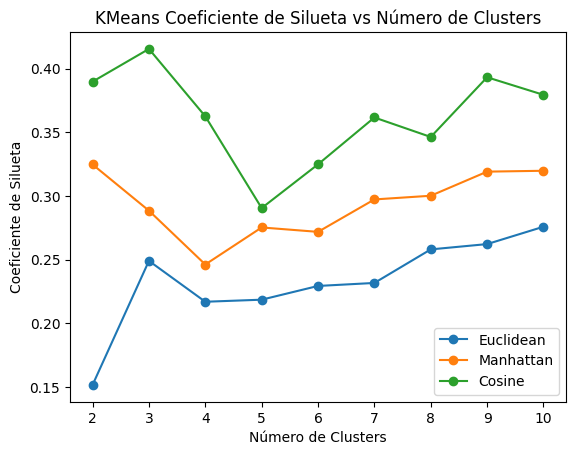

In [22]:
_km_ss_euclidean, _km_ss_manhattan, _km_ss_cosine = calculate_cluster_silhouette_scores_n_cluster(X_base, KMeans(), k_values)
plot_silhouette_scores(k_values, _km_ss_euclidean, _km_ss_manhattan, _km_ss_cosine, 'KMeans')

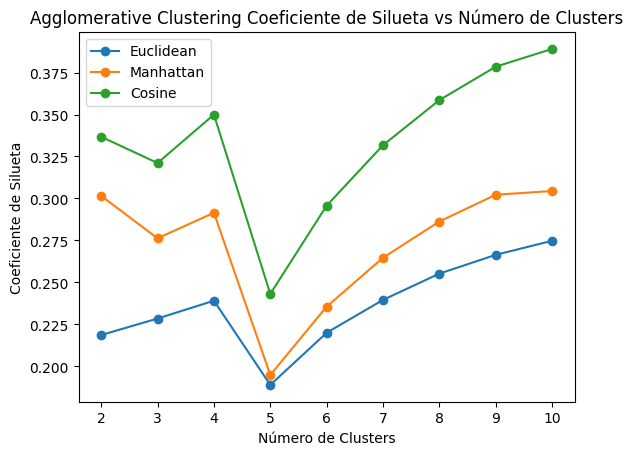

In [164]:
_ac_ss_euclidean, _ac_ss_manhattan, _ac_ss_cosine = calculate_cluster_silhouette_scores_n_cluster(X_base, AgglomerativeClustering(), k_values)
plot_silhouette_scores(k_values, _ac_ss_euclidean, _ac_ss_manhattan, _ac_ss_cosine, 'Agglomerative Clustering')

0.1 Distribucion de clusters euclidean: 
eps value: 0.1
silhouette score: -0.2939208535912063
-1     1721
 1      176
 2       79
 14      35
 0       19
 3       16
 9       11
 11       7
 4        7
 8        7
 13       7
 5        6
 6        5
 7        5
 12       5
 10       5
Name: count, dtype: int64
0.1 Distribucion de clusters manhattan: 
eps value: 0.1
silhouette score: -0.4052353669678009
-1     1843
 1      104
 2       28
 12      25
 0       18
 8       13
 13      13
 11      11
 9       10
 3        7
 5        7
 7        7
 6        5
 4        5
 10       5
 14       5
 15       5
Name: count, dtype: int64
0.1 Distribucion de clusters cosine: 
eps value: 0.1
silhouette score: 0.4524168009342821
 2     930
 0     342
 3     250
-1     144
 7     141
 4      98
 10     69
 9      37
 1      20
 5      19
 11     15
 14     15
 8      14
 6       7
 12      5
 13      5
Name: count, dtype: int64
0.2 Distribucion de clusters euclidean: 
eps value: 0.2
silhouette score

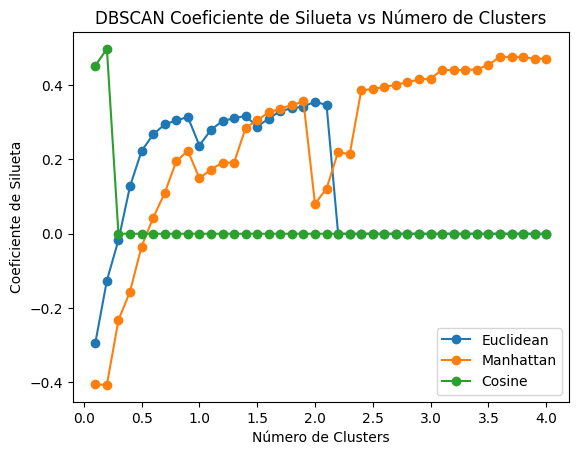

In [114]:
_db_ss_euclidean, _db_ss_manhattan, _db_ss_cosine = calculate_cluster_silhouette_scores_eps(X_base, DBSCAN(), eps_range)
plot_silhouette_scores(eps_range, _db_ss_euclidean, _db_ss_manhattan, _db_ss_cosine, 'DBSCAN')

In [177]:
# best clustering
bs_dbscan = DBSCAN(eps=1.9, metric='manhattan')
bs_labels_dbscan = bs_dbscan.fit_predict(X_base)

# manhattan outliers
o_dbscan = DBSCAN(eps=2.7, metric='manhattan')
om_labels_dbscan = o_dbscan.fit_predict(X_base)

# euclidean outliers
o_dbscan = DBSCAN(eps=0.9, metric='euclidean')
oe_labels_dbscan = o_dbscan.fit_predict(X_base)

In [182]:
x_outliers = X_base[oe_labels_dbscan == -1]
x_regulars = X_base[oe_labels_dbscan != -1]
x_outliers['IMC'] = X['IMC'][oe_labels_dbscan == -1]
x_regulars['IMC'] = X['IMC'][oe_labels_dbscan != -1]

/var/folders/p8/1gk3mtbn3q744dx09hdtpp300000gn/T/ipykernel_85683/2730687672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_outliers['IMC'] = X['IMC'][oe_labels_dbscan == -1]
/var/folders/p8/1gk3mtbn3q744dx09hdtpp300000gn/T/ipykernel_85683/2730687672.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_regulars['IMC'] = X['IMC'][oe_labels_dbscan != -1]


In [183]:
all_pca = PCA(n_components=9, random_state=2024)
X_pca = all_pca.fit_transform(X_base)
all_pca.explained_variance_ratio_.cumsum()

array([0.20650515, 0.38394713, 0.5072174 , 0.61536888, 0.67221496,
       0.72403881, 0.76814097, 0.80743406, 0.84181933])

In [184]:
out_pca = PCA(n_components=15, random_state=2024)
X_out_pca = out_pca.fit_transform(x_outliers.drop(columns=['IMC']))
out_pca.explained_variance_ratio_.cumsum()

array([0.13216322, 0.25421546, 0.35514603, 0.43352516, 0.50762595,
       0.57884103, 0.64494676, 0.70269462, 0.75424279, 0.80129811,
       0.83667605, 0.86569651, 0.89162684, 0.91542357, 0.93640539])

In [185]:
reg_pca = PCA(n_components=7, random_state=2024)
X_reg_pca = reg_pca.fit_transform(x_regulars.drop(columns=['IMC']))
reg_pca.explained_variance_ratio_.cumsum()

array([0.23802637, 0.44178747, 0.5784296 , 0.67982199, 0.73641071,
       0.78380812, 0.82964384])

In [136]:
df_out_pca = pd.DataFrame(X_out_pca)
df_reg_pca = pd.DataFrame(X_reg_pca)
df_out_pca['IMC'] = x_outliers['IMC']
df_reg_pca['IMC'] = x_regulars['IMC']

In [138]:
df_reg_pca.corr()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,IMC
pca0,1.000000e+00,-3.071124e-16,4.836317e-16,6.227360e-16,2.205392e-15,4.624313e-16,1.437409e-15,2.813477e-15,0.167018
pca1,-3.071124e-16,1.000000e+00,-7.102595e-16,-3.649650e-15,-8.204261e-15,-3.202001e-15,-1.125000e-14,-1.591066e-14,-0.215830
pca2,4.836317e-16,-7.102595e-16,1.000000e+00,2.354672e-15,2.257979e-15,-3.793228e-16,4.972916e-15,5.924298e-15,0.084087
pca3,6.227360e-16,-3.649650e-15,2.354672e-15,1.000000e+00,2.047492e-14,8.481961e-15,3.290338e-14,4.710406e-14,0.561087
pca4,2.205392e-15,-8.204261e-15,2.257979e-15,2.047492e-14,1.000000e+00,-5.236287e-15,1.399572e-14,-5.821224e-15,0.152841
pca5,4.624313e-16,-3.202001e-15,-3.793228e-16,8.481961e-15,-5.236287e-15,1.000000e+00,-3.476779e-15,-1.794698e-14,-0.217125
pca6,1.437409e-15,-1.125000e-14,4.972916e-15,3.290338e-14,1.399572e-14,-3.476779e-15,1.000000e+00,1.256278e-14,-0.046201
pca7,2.813477e-15,-1.591066e-14,5.924298e-15,4.710406e-14,-5.821224e-15,-1.794698e-14,1.256278e-14,1.000000e+00,-0.022364
IMC,1.670180e-01,-2.158298e-01,8.408667e-02,5.610865e-01,1.528409e-01,-2.171248e-01,-4.620050e-02,-2.236362e-02,1.000000


In [141]:
pd.DataFrame(reg_pca.components_, columns=x_regulars.drop(columns=['IMC']).columns)

,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Always,...,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,Age,FCVC,NCP,CH2O,FAF,TUE
0,-0.227624,-0.134981,-0.004634,0.000000e+00,0.031207,-0.055850,0.024643,0.004477,0.024438,0.000000e+00,...,-1.262177e-29,0.000000e+00,0.300446,0.000498,-0.056916,0.075591,0.024125,0.027518,-0.069170,-0.017135
1,-0.355087,-0.159975,-0.102055,5.551115e-17,0.213737,-0.221388,0.007652,-0.004239,0.031673,-8.470329e-22,...,0.000000e+00,0.000000e+00,0.490010,-0.009942,-0.113187,0.042045,-0.066714,-0.051977,0.007565,0.090257
2,0.767916,0.142752,0.071086,-8.326673e-17,-0.145084,0.124475,0.020609,0.013626,-0.036340,0.000000e+00,...,0.000000e+00,0.000000e+00,0.362197,0.005307,-0.090902,-0.136261,0.034038,0.144716,0.124565,0.123391
3,-0.391972,0.517518,0.094341,-0.000000e+00,-0.428426,0.531041,-0.102615,-0.000773,-0.031455,-2.168404e-19,...,1.654361e-24,-0.000000e+00,0.127245,-0.002467,0.012088,0.148519,0.045885,0.122311,-0.071100,0.100064
4,-0.027653,0.433462,-0.002263,1.526557e-16,0.319166,-0.337621,0.018456,-0.008689,-0.061402,1.110223e-16,...,-1.084202e-19,2.710505e-20,-0.024216,0.003811,0.015749,0.271537,0.255318,0.591208,0.247746,-0.198590
5,-0.135842,-0.414659,0.036647,2.775558e-17,-0.126290,0.102806,0.023484,-0.016633,0.046951,-8.326673e-17,...,1.734723e-18,-0.000000e+00,-0.104063,0.004588,-0.103803,-0.032626,0.085984,0.417299,0.440750,0.605315
6,-0.001890,0.363031,0.171700,1.045171e-16,0.310437,-0.166874,-0.143564,0.015920,-0.031249,-2.428613e-17,...,-1.110223e-16,-0.000000e+00,-0.042287,0.009084,-0.030903,-0.086874,0.365197,-0.418457,-0.066544,0.601198
7,0.043144,-0.123498,-0.338545,-6.884684e-17,-0.050100,0.209330,-0.159230,0.018624,0.020986,-2.220446e-16,...,-1.387779e-17,0.000000e+00,0.031370,-0.002882,-0.037958,0.295639,0.481420,-0.389892,0.510728,-0.244335


## Concluiones clustering
Despues de remover los outliers encontramos que la explicabilidad del modelo por medio de PCA incremento de forma sustancial, lo cual nos permitio reducir el numero de componentes usados para tener una explicabilidad superior del 80%, pasando de 9 a 6-7 componentes, esto fue significativo ya que incremento la explicabilidad en aproximadamente 6%.

# Entrenamiento del modelo

In [173]:
class ModelSearchTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model, param_grid):
        self.model = model
        self.param_grid = param_grid
        self.best_estimator_ = None

    def fit(self, X, y=None):
        search = GridSearchCV(clone(self.model), param_grid=self.param_grid, scoring='f1_weighted', n_jobs=-1, verbose=1)
        search.fit(X, y)
        self.best_estimator_ = search.best_estimator_
        return self

    def transform(self, X):
        return self.best_estimator_.predict(X).reshape(-1, 1)


rf_transformer = ModelSearchTransformer(
    RandomForestClassifier(random_state=20241114),
    {
        'n_estimators': [120, 150, 180],
        'max_depth': [2, 5, 8],
        'min_samples_split': [4, 6, 8],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True]
    }
)

gb_transformer = ModelSearchTransformer(
    GradientBoostingClassifier(random_state=20241114),
    {
        'n_estimators': [120, 150, 180],
        'max_depth': [2, 5, 8],
        'min_samples_split': [4, 6, 8],
        'min_samples_leaf': [1, 2],
        'learning_rate': [0.1, 0.05]
    }
)

nb_transformer = ModelSearchTransformer(
    GaussianNB(),
    {}
)

svc_transformer = ModelSearchTransformer(
    SVC(random_state=20241114),
    {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
)

lr_transformer = ModelSearchTransformer(
    LogisticRegression(random_state=20241114, max_iter=10000),
    {
        'C': [0.1, 1, 10],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
)


models_search_pipeline = make_column_transformer(
    (make_pipeline(
        preprocessor,
        rf_transformer
    ), make_column_selector()),
    (make_pipeline(
        preprocessor,
        gb_transformer
    ), make_column_selector()),
    (make_pipeline(
        preprocessor,
        nb_transformer
    ), make_column_selector()),
    (make_pipeline(
        preprocessor,
        svc_transformer
    ), make_column_selector()),
    (make_pipeline(
        preprocessor,
        lr_transformer
    ), make_column_selector()),
    n_jobs=-1
)

In [152]:
df_obesity.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad', 'IMC'],
      dtype='object')

### Remove outliers

In [187]:
outliers_dbscan = DBSCAN(eps=0.9, metric='euclidean')
outliers_labels = outliers_dbscan.fit_predict(X_base)
df_no_outliers = df_obesity[outliers_labels != -1]  # remove outliers
df_obesity.shape, df_no_outliers.shape

((2111, 18), (1840, 18))

### Encode target

In [188]:
y_label_encoder = LabelEncoder()
y_encoder = y_label_encoder.fit(df_no_outliers['NObeyesdad'])
y_encoded = y_encoder.transform(df_no_outliers['NObeyesdad'])

### Train/Test split

In [189]:
X_train, X_test, y_train, y_test = train_test_split(df_no_outliers.drop(columns=['NObeyesdad', 'IMC', 'Height', 'Weight']), y_encoded, test_size=0.2, random_state=20241114)

In [190]:
trained_search_pipeline = models_search_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [193]:
for pipe in models_search_pipeline.transformers_:
    best_model = pipe[1].named_steps['modelsearchtransformer'].best_estimator_
    print(best_model)
    y_pred = pipe[1].transform(X_test)
    try:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    except:
        print("No confusion matrix")
    print(classification_report(y_test, y_pred))

RandomForestClassifier(max_depth=8, min_samples_split=4, n_estimators=120,
                       random_state=20241114)
No confusion matrix
              precision    recall  f1-score   support

           0       0.85      0.92      0.89        38
           1       0.71      0.43      0.53        28
           2       0.70      0.90      0.79        58
           3       0.72      0.98      0.83        51
           4       0.99      1.00      0.99        74
           5       0.86      0.76      0.81        58
           6       0.83      0.56      0.67        61

    accuracy                           0.82       368
   macro avg       0.81      0.79      0.79       368
weighted avg       0.82      0.82      0.81       368

GradientBoostingClassifier(max_depth=8, min_samples_split=6, n_estimators=180,
                           random_state=20241114)
No confusion matrix
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        38
    

/Users/sero/Documents/datascience_master/ml1/workdir/final_project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sero/Documents/datascience_master/ml1/workdir/final_project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sero/Documents/datascience_master/ml1/workdir/final_project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

In [201]:
import joblib
from pathlib import Path


root_project = Path.cwd().parent
models_path = root_project / 'models'

best_overall_model = models_search_pipeline.transformers_[1][1].named_steps['modelsearchtransformer'].best_estimator_
joblib.dump(best_overall_model, models_path / 'best_overall_model.joblib')

['/Users/sero/Documents/datascience_master/ml1/workdir/final_project/models/best_overall_model.joblib']

In [202]:
best_overall_model

GradientBoostingClassifier(max_depth=8, min_samples_split=6, n_estimators=180,
                           random_state=20241114)